# Clasificación con modelos lineales en Python
En este taller vamos a tener una vista general de como hacer una clasificación lineal en Python, principalmente utilizando las librerias de Pandas, scitkit-learn y statsmodels. El objetivo es entender el proceso tipico sin profundizar demasiado en los distintos pasos.

In [21]:
import statsmodels.api as sm
import pandas as pd 
import plotnine as pn
import sklearn
import numpy as np


data_location = 'tweet_and_user_data.csv'

pd.options.display.max_columns = 500

## Los datos
Echamos un vistazo rapido a los datos que vamos a utilizar

In [22]:
tweet_data = pd.read_csv(data_location)

C:\Users\guille\AppData\Local\Temp\ipykernel_12904\1431630765.py:1: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.


In [23]:
tweet_data.shape

(40581, 56)

In [24]:
tweet_data.head()

,id,conversation_id,created_at,date,timezone,place,tweet,language,hashtags,cashtags,user_id,user_id_str,username,name,day,hour,link,urls,photos,video,thumbnail,retweet,nlikes,nreplies,nretweets,quote_url,search,near,geo,source,user_rt_id,user_rt,retweet_id,reply_to,retweet_date,translate,trans_src,trans_dest,id_user,name_user,username_user,bio,url,join_datetime,join_date,join_time,tweets,location,following,followers,likes,media,private,verified,avatar,background_image
0,1425590913959612419,1425590913959612419,1.628722e+12,2021-08-12 00:52:14,200,NaN,RT @girlsalliance: We're so proud of the four ...,en,[],[],409486555,409486555,MichelleObama,Michelle Obama,4,0,https://twitter.com/MichelleObama/status/14255...,[],[],0,NaN,True,0,0,232,0,NaN,NaN,NaN,NaN,1.047165e+18,We're so proud of the four organizations in ou...,1.425590e+18,[],2021-08-12 00:46:58 CEST,NaN,NaN,NaN,409486555,Michelle Obama,MichelleObama,Girl from the South Side and former First Lady...,https://t.co/HPYP9ad13Y,2011-11-10 20:13:01 UTC,2011-11-10,20:13:01 UTC,1770,"Washington, DC",16,20854298,184,461,False,True,https://pbs.twimg.com/profile_images/136674780...,https://pbs.twimg.com/profile_banners/40948655...
1,1427736867739299841,1427736867739299841,1.629234e+12,2021-08-17 22:59:29,200,NaN,Some casual suggestions to 😏SLIDE😏 into when u...,en,"['shoesdaytuesday', 'afterskewlslide']",[],21447363,21447363,katyperry,KATY PERRY,2,22,https://twitter.com/katyperry/status/142773686...,[],['https://pbs.twimg.com/media/E9BXG4YVkAAl3_A....,1,https://pbs.twimg.com/media/E9BXG4YVkAAl3_A.jpg,False,5266,368,408,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN,21447363,KATY PERRY,katyperry,Love. Light.,https://t.co/Rrwt0Kj2Q7,2009-02-20 23:45:56 UTC,2009-02-20,23:45:56 UTC,11420,NaN,235,108819032,7995,2170,False,True,https://pbs.twimg.com/profile_images/139246535...,https://pbs.twimg.com/profile_banners/21447363...
2,1427667300488937476,1427667300488937476,1.629217e+12,2021-08-17 18:23:03,200,NaN,RT @ValaAfshar: You are not your job.,en,[],[],21447363,21447363,katyperry,KATY PERRY,2,18,https://twitter.com/katyperry/status/142766730...,[],[],0,NaN,True,0,0,764,0,NaN,NaN,NaN,NaN,2.597252e+08,You are not your job.,1.427648e+18,[],2021-08-17 17:05:53 CEST,NaN,NaN,NaN,21447363,KATY PERRY,katyperry,Love. Light.,https://t.co/Rrwt0Kj2Q7,2009-02-20 23:45:56 UTC,2009-02-20,23:45:56 UTC,11420,NaN,235,108819032,7995,2170,False,True,https://pbs.twimg.com/profile_images/139246535...,https://pbs.twimg.com/profile_banners/21447363...
3,1427667012105371652,1427667012105371652,1.629217e+12,2021-08-17 18:21:55,200,NaN,What have we become 😔😂 Toddler Cites Freedom ...,en,[],[],21447363,21447363,katyperry,KATY PERRY,2,18,https://twitter.com/katyperry/status/142766701...,['https://www.theonion.com/toddler-cites-freed...,[],0,NaN,False,5638,476,438,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN,21447363,KATY PERRY,katyperry,Love. Light.,https://t.co/Rrwt0Kj2Q7,2009-02-20 23:45:56 UTC,2009-02-20,23:45:56 UTC,11420,NaN,235,108819032,7995,2170,False,True,https://pbs.twimg.com/profile_images/139246535...,https://pbs.twimg.com/profile_banners/21447363...
4,1427497703596990467,1427497703596990467,1.629177e+12,2021-08-17 07:09:08,200,NaN,The tech giants that refuse to massively addre...,en,[],[],21447363,21447363,katyperry,KATY PERRY,2,7,https://twitter.com/katyperry/status/142749770...,[],[],0,NaN,False,8810,546,1211,https://twitter.com/VICENews/status/1427311204...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN,21447363,KATY PERRY,katyperry,Love. Light.,https://t.co/Rrwt0Kj2Q7,2009-02-20 23:45:56 UTC,2009-02-20,23:45:56 UTC,11420,NaN,235,108819032,7995,2170,False,True,https://pbs.twimg.com/profile_images/139246535...,https://pbs.twimg.com/profile_banners/21447363...


## Nuestra prediccion

In [25]:
tweet_data.nlikes.quantile([0.5, 0.75, 0.9, 0.95, 0.99])

0.50       39.0
0.75      198.0
0.90     1318.0
0.95     4319.0
0.99    25868.0
Name: nlikes, dtype: float64

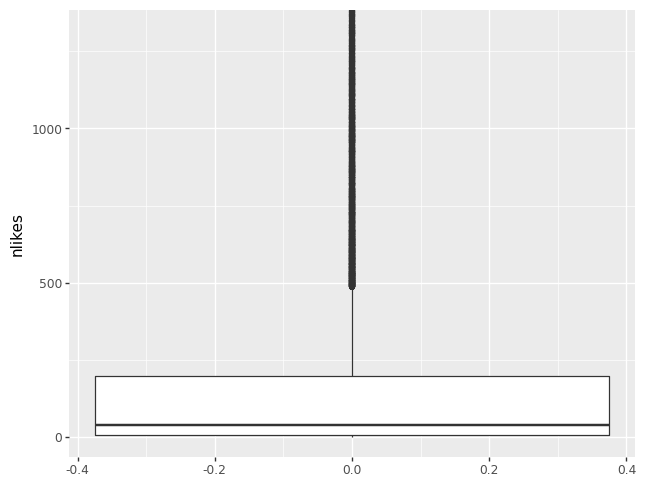

In [26]:
graph = (
    pn.ggplot(tweet_data, pn.aes(x='0', y='nlikes'))
    + pn.geom_boxplot()
    + pn.coord_cartesian(ylim=[0, tweet_data.nlikes.quantile(0.90)])
    + pn.xlab('')
)

graph.draw()

In [27]:
target = 'is_popular'
cutoff = 50
tweet_data[target] = (tweet_data.nlikes >= cutoff).astype(int)

tweet_data[target].value_counts(normalize=True, dropna=False) * 100

is_popular
0    53.943964
1    46.056036
Name: proportion, dtype: float64

In [28]:
import sklearn.model_selection


train, test = sklearn.model_selection.train_test_split(tweet_data, train_size=0.7, random_state=0)

train = train.reset_index(drop=True)
test = test.reset_index(drop=True)

print(train.shape)
print(test.shape)

(28406, 57)
(12175, 57)


In [29]:
potential_variables = [
    'followers', 'following', 'video', 'retweet', 'tweets', 'likes', 'media', 'verified'
]

for variable in potential_variables:
    print(f'For variable {variable}:')
    print(train.groupby(target)[variable].agg(['mean', 'sem']))
    print('\n')

For variable followers:
                    mean            sem
is_popular                             
0           6.182150e+06   71263.036395
1           1.421613e+07  133938.264897


For variable following:
                    mean          sem
is_popular                           
0           17022.785677  1758.908416
1            6084.765074   743.757493


For variable video:
                mean       sem
is_popular                    
0           0.158651  0.002953
1           0.309037  0.004037


For variable retweet:
                mean       sem
is_popular                    
0           0.282802  0.003641
1           0.000000  0.000000


For variable tweets:
                     mean          sem
is_popular                            
0           178786.712755  1171.194109
1           176844.335369  1344.078084


For variable likes:
                    mean         sem
is_popular                          
0           18891.473144  531.793458
1            8485.324073  237.75

In [30]:
train[potential_variables].isna().sum()

followers    0
following    0
video        0
retweet      0
tweets       0
likes        0
media        0
verified     0
dtype: int64

## Hacemos la primera predicción

In [31]:
X_variables = ['following', 'video']

In [55]:
log_model = sm.Logit(train[target], sm.add_constant(train[X_variables]))
log_model = log_model.fit()

predictions = log_model.predict(sm.add_constant(train[X_variables]))

Optimization terminated successfully.
         Current function value: 0.435133
         Iterations 27


In [33]:
pd.concat([
    train[target], predictions, predictions.round().astype(bool)
], axis=1)

,is_popular,0,1
0,0,0.413944,False
1,1,0.625712,True
2,1,0.414082,False
3,1,0.414163,False
4,0,0.626044,True
...,...,...,...
28401,1,0.626061,True
28402,1,0.413255,False
28403,1,0.625988,True
28404,1,0.414165,False


In [34]:
train['predictions_1'] = predictions

## Evaluando los resultados

In [35]:
log_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             is_popular   No. Observations:                28406
Model:                          Logit   Df Residuals:                    28403
Method:                           MLE   Df Model:                            2
Date:                Thu, 02 May 2024   Pseudo R-squ.:                 0.02398
Time:                        10:47:01   Log-Likelihood:                -19134.
converged:                       True   LL-Null:                       -19604.
Covariance Type:            nonrobust   LLR p-value:                6.442e-205
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.3467      0.014    -25.202      0.000      -0.374      -0.320
following  -5.484e-07   1.31e-07     -4.185      0.000   -8.05e-07   -2.92e-07
video          0.8620      0.029     29.610      0.000       0.805       0.919
==============================================================================
"""

In [36]:
np.exp(log_model.params)

const        0.707048
following    0.999999
video        2.367931
dtype: float64

Estos son los "odds" - cuando por encima de 1 significa que la probabilidad sube.
Loss odds se convierten a probabilidad mediante la formula `odds = p / (1 - p)` 

In [37]:
np.exp(log_model.params) / (np.exp(log_model.params) + 1)

const        0.414194
following    0.500000
video        0.703082
dtype: float64

In [38]:
odds_1 = np.exp(log_model.params[0] + log_model.params[1] + log_model.params[2])
odds_2 = np.exp(log_model.params[0] + log_model.params[1])

(odds_1 / (odds_1 + 1)) - (odds_2 / (odds_2 + 1))

C:\Users\guille\AppData\Local\Temp\ipykernel_12904\1857375259.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
C:\Users\guille\AppData\Local\Temp\ipykernel_12904\1857375259.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


0.21186869811823006

In [39]:
train['video'] = train.video.astype(bool)

graph = (
    pn.ggplot(train, pn.aes(x='following', y='predictions_1', color='video'))
    + pn.geom_line()
    + pn.ylab('Probability of being popular')
)

graph.draw();

In [40]:
test['predictions_1'] = log_model.predict(sm.add_constant(test[X_variables]))

In [41]:
auc_train = sklearn.metrics.roc_auc_score(train[target], train['predictions_1'])
auc_test = sklearn.metrics.roc_auc_score(test[target], test['predictions_1'])

acc_train = sklearn.metrics.accuracy_score(train[target], train['predictions_1'].round())
acc_test = sklearn.metrics.accuracy_score(test[target], test['predictions_1'].round())

print(f'The auc in train is {auc_train:.3} and in test it is {auc_test:.3}, the accuracies are {acc_train:.1%} and {acc_test:.1%}')

The auc in train is 0.642 and in test it is 0.63, the accuracies are 59.6% and 59.6%


In [42]:
(sklearn.metrics.confusion_matrix(test[target], test['predictions_1'].round()) / test.shape[0]).round(2) * 100

array([[46.,  8.],
       [32., 14.]])

## Mejorando el modelo

In [43]:
train['video'] = train.video.astype(int)

In [44]:
# Probamos cambiar la variable
X_variables = ['followers', 'video']

log_model = sm.Logit(train[target], sm.add_constant(train[X_variables]))
log_model = log_model.fit()

train['predictions_2'] = log_model.predict(sm.add_constant(train[X_variables]))
test['predictions_2'] = log_model.predict(sm.add_constant(test[X_variables]))

print(log_model.summary())

auc_train = sklearn.metrics.roc_auc_score(train[target], train['predictions_2'])
auc_test = sklearn.metrics.roc_auc_score(test[target], test['predictions_2'])

acc_train = sklearn.metrics.accuracy_score(train[target], train['predictions_2'].round())
acc_test = sklearn.metrics.accuracy_score(test[target], test['predictions_2'].round())

print(f'The auc in train is {auc_train:.3} and in test it is {auc_test:.3}, the accuracies are {acc_train:.1%} and {acc_test:.1%}')

Optimization terminated successfully.
         Current function value: 0.618219
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:             is_popular   No. Observations:                28406
Model:                          Logit   Df Residuals:                    28403
Method:                           MLE   Df Model:                            2
Date:                Thu, 02 May 2024   Pseudo R-squ.:                  0.1042
Time:                        10:47:02   Log-Likelihood:                -17561.
converged:                       True   LL-Null:                       -19604.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.9748      0.019    -51.400      0.000      -1.012      -0.938
followers   6.779e-08   1.51e

In [45]:
train['verified'] = train.verified.astype(int)
train['retweet'] = train.retweet.astype(int)

test['verified'] = test.verified.astype(int)
test['retweet'] = test.retweet.astype(int)

In [46]:
X_variables = [
    'followers', 'following', 'video', 'tweets', 'likes', 'media'
]

log_model = sm.Logit(train[target], sm.add_constant(train[X_variables]))
log_model = log_model.fit()

train['predictions_3'] = log_model.predict(sm.add_constant(train[X_variables]))
test['predictions_3'] = log_model.predict(sm.add_constant(test[X_variables]))

print(log_model.summary())

auc_train = sklearn.metrics.roc_auc_score(train[target], train['predictions_3'])
auc_test = sklearn.metrics.roc_auc_score(test[target], test['predictions_3'])

acc_train = sklearn.metrics.accuracy_score(train[target], train['predictions_3'].round())
acc_test = sklearn.metrics.accuracy_score(test[target], test['predictions_3'].round())

print(f'The auc in train is {auc_train:.3} and in test it is {auc_test:.3}, the accuracies are {acc_train:.1%} and {acc_test:.1%}')

Optimization terminated successfully.
         Current function value: 0.607681
         Iterations 6


                           Logit Regression Results                           
Dep. Variable:             is_popular   No. Observations:                28406
Model:                          Logit   Df Residuals:                    28399
Method:                           MLE   Df Model:                            6
Date:                Thu, 02 May 2024   Pseudo R-squ.:                  0.1195
Time:                        10:47:02   Log-Likelihood:                -17262.
converged:                       True   LL-Null:                       -19604.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.7340      0.024    -30.854      0.000      -0.781      -0.687
followers   6.876e-08    1.6e-09     42.863      0.000    6.56e-08    7.19e-08
following  -4.067e-07   1.18e-07     -3.448      0.0

### Creando nuevas variables

In [47]:
# Tiene hashtags?
train['has_hashtags'] = (train.hashtags.str.len() > 2).astype(int)

# Es en ingles
train['is_english'] = (train.language == 'en').astype(int)

# Media de likes etc. para sus posts del pasado
train['avg_likes'] = train.likes / train.tweets
train['followers_per_tweet'] = train.followers / train.tweets

# Es un reply?
train['is_reply'] = (train.reply_to.str.len() > 2).astype(int)

In [48]:
potential_variables = [
    'has_hashtags', 'is_english', 'avg_likes', 'followers_per_tweet', 'is_reply'
]

for variable in potential_variables:
    print(f'For variable {variable}:')
    print(train.groupby(target)[variable].agg(['mean', 'sem']))
    print('\n')

For variable has_hashtags:
                mean       sem
is_popular                    
0           0.129378  0.002713
1           0.135094  0.002986


For variable is_english:
                mean       sem
is_popular                    
0           0.768231  0.003411
1           0.724775  0.003902


For variable avg_likes:
                mean       sem
is_popular                    
0           0.313166  0.009141
1           0.197461  0.006216


For variable followers_per_tweet:
                  mean        sem
is_popular                       
0           154.246816   8.671468
1           394.015048  13.538256


For variable is_reply:
                mean       sem
is_popular                    
0           0.144211  0.002840
1           0.045642  0.001823




In [49]:
# Tiene hashtags?
test['has_hashtags'] = (test.hashtags.str.len() > 2).astype(int)

# Es en ingles
test['is_english'] = (test.language == 'en').astype(int)

# Media de likes etc. para sus posts del pasado
test['avg_likes'] = test.likes / test.tweets
test['followers_per_tweet'] = test.followers / test.tweets

# Es un reply?
test['is_reply'] = (test.reply_to.str.len() > 2).astype(int)

In [56]:
X_variables = [
    'followers', 'following', 'video', 'retweet', 'tweets', 'likes', 'media', 'verified', 
    'has_hashtags', 'is_english', 'avg_likes', 'followers_per_tweet', 'is_reply'
]

log_model = sm.Logit(train[target], sm.add_constant(train[X_variables]))
log_model = log_model.fit()

train['predictions_4'] = log_model.predict(sm.add_constant(train[X_variables]))
test['predictions_4'] = log_model.predict(sm.add_constant(test[X_variables]))

print(log_model.summary())

auc_train = sklearn.metrics.roc_auc_score(train[target], train['predictions_4'])
auc_test = sklearn.metrics.roc_auc_score(test[target], test['predictions_4'])

acc_train = sklearn.metrics.accuracy_score(train[target], train['predictions_4'].round())
acc_test = sklearn.metrics.accuracy_score(test[target], test['predictions_4'].round())

print(f'The auc in train is {auc_train:.3} and in test it is {auc_test:.3}, the accuracies are {acc_train:.1%} and {acc_test:.1%}')

Optimization terminated successfully.
         Current function value: 0.435133
         Iterations 27
                           Logit Regression Results                           
Dep. Variable:             is_popular   No. Observations:                28406
Model:                          Logit   Df Residuals:                    28392
Method:                           MLE   Df Model:                           13
Date:                Thu, 02 May 2024   Pseudo R-squ.:                  0.3695
Time:                        10:52:17   Log-Likelihood:                -12360.
converged:                       True   LL-Null:                       -19604.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   1.0818      0.098     10.998      0.000       0.889       1.275
f

Con los modelos lineales, las variables suelen ser la mejor fuente de mejoras. Statsmodels tiene una manera de entrenar el modelo que utiliza una "formula" - un concepto inventado en R que puede facilitar la declaración del modelo y "interacciones" entre variables.

In [51]:
import statsmodels.formula.api as smf

In [52]:
formula = f'{target} ~ followers * video'

log_model = smf.logit(formula=formula, data=train)
log_model = log_model.fit()

train['predictions_5'] = log_model.predict(train)
test['predictions_5'] = log_model.predict(test)

print(log_model.summary())

auc_train = sklearn.metrics.roc_auc_score(train[target], train['predictions_5'])
auc_test = sklearn.metrics.roc_auc_score(test[target], test['predictions_5'])

acc_train = sklearn.metrics.accuracy_score(train[target], train['predictions_5'].round())
acc_test = sklearn.metrics.accuracy_score(test[target], test['predictions_5'].round())

print(f'The auc in train is {auc_train:.3} and in test it is {auc_test:.3}, the accuracies are {acc_train:.1%} and {acc_test:.1%}')

Optimization terminated successfully.
         Current function value: 0.617856
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:             is_popular   No. Observations:                28406
Model:                          Logit   Df Residuals:                    28402
Method:                           MLE   Df Model:                            3
Date:                Thu, 02 May 2024   Pseudo R-squ.:                  0.1047
Time:                        10:47:03   Log-Likelihood:                -17551.
converged:                       True   LL-Null:                       -19604.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          -0.9518      0.020    -48.707      0.000      -0.990      -0.914
followers     

### La curva de precision recall

In [53]:
results = []
renames = {0 : 'recall', 1 : 'precision', 2 : 'threshold'}
for i in range(1, 6):
    result = pd.DataFrame(sklearn.metrics.precision_recall_curve(test[target], test[f'predictions_{i}'])).transpose().rename(columns=renames)
    result['prediction_number'] = str(i)
    results.append(result)
    
results = pd.concat(results) 

results['threshold'] = results.threshold.round(3)

results = results.groupby(['prediction_number', 'threshold']).head(1)

results['recall_diff'] = results.groupby('prediction_number').recall.diff()
results['precision_diff'] = results.groupby('prediction_number').precision.diff()

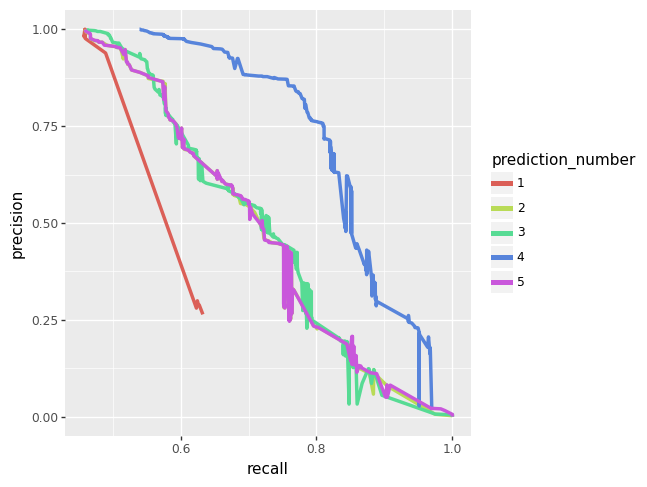

In [58]:
c = (results.recall_diff >= 0)
graph = (
    pn.ggplot(results[c], pn.aes(x='recall', y='precision', color='prediction_number'))
    + pn.geom_line(size=1.4)
)

graph.draw()